# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


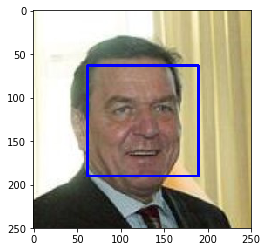

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 99% of humans, and 11% of dogs

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
humans = 0
dogs = 0

for human in human_files_short:
    if face_detector(human):
        humans += 1

for dog in dog_files_short:
    if face_detector(dog):
        dogs += 1
        
print('{} human faces'.format(humans/100))
print('{} dog faces'.format(dogs/100))

0.99 human faces
0.11 dog faces


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ yes and no. If possible, a person should present an unobstructed face; however, it is not always possible nor understandable nor physically doable. There may be religious reasons (nakab) or physical reasons such as disfigurements and/or disabilities, and then there are positional issues such as someone whom is at a more oblique angle because they are very tall or short.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [5]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [7]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ no human faces detected, but 100% on dog faces

In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
humans = 0
dogs = 0

for human in human_files_short:
    if dog_detector(human):
        humans += 1

for dog in dog_files_short:
    if dog_detector(dog):
        dogs += 1
        
print('{}% human faces'.format(humans))
print('{}% dog faces'.format(dogs))

0% human faces
100% dog faces


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [9]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:02<00:00, 331.45it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I used Conv2D layers with kernel sizes set to 3 leaving a default 1-step window and a relu activation. I pooled between each convolutional layer using a max pooling kernel of 2 so that it wouldnt alias too much information, but still enabling the high SNR features to flow through. After 4 convolutional layers, I flattened the information and connected it to two fully-connected 1024 nodes with a relu activation finally ending in a 133 node softmax layer for each of the 133 classifiable dog breeds adding 20% dropoutrates between those layers.

In [10]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       73856     
__________

### Compile the Model

In [56]:
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [57]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 30

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=128, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 14s 2ms/step - loss: 4.9312 - acc: 0.0093 - val_loss: 4.8712 - val_acc: 0.0096
Epoch 2/30
6680/6680 [==============================] - 12s 2ms/step - loss: 4.8656 - acc: 0.0102 - val_loss: 4.8738 - val_acc: 0.0096
Epoch 3/30
6680/6680 [==============================] - 12s 2ms/step - loss: 4.8911 - acc: 0.0111 - val_loss: 4.8416 - val_acc: 0.0132
Epoch 4/30
6680/6680 [==============================] - 12s 2ms/step - loss: 4.7806 - acc: 0.0160 - val_loss: 4.6716 - val_acc: 0.0228
Epoch 5/30
6680/6680 [==============================] - 12s 2ms/step - loss: 4.6645 - acc: 0.0225 - val_loss: 4.6338 - val_acc: 0.0299
Epoch 6/30
6680/6680 [==============================] - 12s 2ms/step - loss: 4.5256 - acc: 0.0331 - val_loss: 4.5972 - val_acc: 0.0335
Epoch 7/30
6680/6680 [==============================] - 12s 2ms/step - loss: 4.3736 - acc: 0.0448 - val_loss: 4.5084 - val_acc: 0.0419
Epoch 8/

### Load the Model with the Best Validation Loss

In [58]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [59]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 6.1005%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [11]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [14]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [62]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [63]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=128, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 249us/step - loss: 12.3761 - acc: 0.0907 - val_loss: 10.7557 - val_acc: 0.1509
Epoch 2/20
6680/6680 [==============================] - 1s 82us/step - loss: 9.6609 - acc: 0.2412 - val_loss: 9.4856 - val_acc: 0.2383
Epoch 3/20
6680/6680 [==============================] - 1s 85us/step - loss: 8.5883 - acc: 0.3397 - val_loss: 8.8601 - val_acc: 0.3066
Epoch 4/20
6680/6680 [==============================] - 1s 87us/step - loss: 8.1295 - acc: 0.3976 - val_loss: 8.4146 - val_acc: 0.3509
Epoch 5/20
6680/6680 [==============================] - 1s 82us/step - loss: 7.8175 - acc: 0.4401 - val_loss: 8.3014 - val_acc: 0.3413
Epoch 6/20
6680/6680 [==============================] - 1s 81us/step - loss: 7.5183 - acc: 0.4772 - val_loss: 8.0372 - val_acc: 0.3832
Epoch 7/20
6680/6680 [==============================] - 1s 87us/step - loss: 7.3986 - acc: 0.5007 - val_loss: 7.9394 - val_acc: 0.3988
Epoch

### Load the Model with the Best Validation Loss

In [18]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [65]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.3014%


### Predict Dog Breed with the Model

In [12]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [13]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_resnet = bottleneck_features['train']
valid_resnet = bottleneck_features['valid']
test_resnet = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I decided to use the ResNet-50 NN for trainsfer training due to its high-ability to classify different images types. This I believed would be key in this test as it would already be pre-trained on many different shapes, textures, patterns, and colors that would give it a key advantage in classification of dog breeds. For my architecture, during the course, we learned that adding a GlobalAveragePooling layer is a known good way to use pre-processed ResNet-50 data for transfer training, so it became my 1st layer, after that I added two more fully connected layers, one being 1/2 the size of the input data with a relu activation (to combat vanishing gradients) and the next being half of that. I fel this would help "down-sample" the data to the final shape of 133 nodes while also giving the final model enough variability to detect between breeds with subtle differences. Finally the last layer, being for classification, uses a 133 nodes with a softmax activation so that breeds can be predicted with a degree of certainty. I then added dropout layers between each layer to minimize overfitting by allowing 10% of the nodes to be dropped between epochs.


In [42]:
### TODO: Define your architecture.
my_model = Sequential()
my_model.add(GlobalAveragePooling2D(input_shape=train_resnet.shape[1:]))
my_model.add(Dropout(0.1))
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dropout(0.1))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dropout(0.1))
my_model.add(Dense(133, activation='softmax'))

my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 133)               68229     
Total para

### (IMPLEMENTATION) Compile the Model

In [43]:
### TODO: Compile the model.
my_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [44]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.my_model.hdf5', 
                               verbose=1, save_best_only=True)

my_model.fit(train_resnet, train_targets, 
          validation_data=(valid_resnet, valid_targets),
          epochs=1000, batch_size=1024, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/1000
6680/6680 [==============================] - 3s 451us/step - loss: 4.4311 - acc: 0.1090 - val_loss: 3.3260 - val_acc: 0.2683
Epoch 2/1000
6680/6680 [==============================] - 0s 28us/step - loss: 2.6308 - acc: 0.3904 - val_loss: 1.6712 - val_acc: 0.5174
Epoch 3/1000
6680/6680 [==============================] - 0s 29us/step - loss: 1.2997 - acc: 0.6418 - val_loss: 1.1032 - val_acc: 0.6838
Epoch 4/1000
6680/6680 [==============================] - 0s 32us/step - loss: 0.7805 - acc: 0.7648 - val_loss: 0.8464 - val_acc: 0.7353
Epoch 5/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.5354 - acc: 0.8332 - val_loss: 0.9699 - val_acc: 0.7042
Epoch 6/1000
6680/6680 [==============================] - 0s 30us/step - loss: 0.4943 - acc: 0.8521 - val_loss: 0.7270 - val_acc: 0.7689
Epoch 7/1000
6680/6680 [==============================] - 0s 28us/step - loss: 0.3834 - acc: 0.8781 - val_loss: 0.6430 - val_acc: 

6680/6680 [==============================] - 0s 18us/step - loss: 0.0133 - acc: 0.9979 - val_loss: 0.6300 - val_acc: 0.8359
Epoch 31/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0133 - acc: 0.9981 - val_loss: 0.6139 - val_acc: 0.8395
Epoch 32/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0171 - acc: 0.9963 - val_loss: 0.6163 - val_acc: 0.8407
Epoch 33/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0242 - acc: 0.9945 - val_loss: 0.5904 - val_acc: 0.8491
Epoch 34/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0132 - acc: 0.9982 - val_loss: 0.6117 - val_acc: 0.8515
Epoch 35/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0186 - acc: 0.9964 - val_loss: 0.6103 - val_acc: 0.8503
Epoch 36/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0102 - acc: 0.9985 - val_loss: 0.5999 - val_acc: 0.8575
Epoch 37/1000
6680/6680 [=======================

Epoch 62/1000
6680/6680 [==============================] - 0s 20us/step - loss: 14.5103 - acc: 0.0991 - val_loss: 14.4521 - val_acc: 0.1018
Epoch 63/1000
6680/6680 [==============================] - 0s 19us/step - loss: 14.3499 - acc: 0.1063 - val_loss: 14.4208 - val_acc: 0.1018
Epoch 64/1000
6680/6680 [==============================] - 0s 18us/step - loss: 14.2349 - acc: 0.1121 - val_loss: 7.0719 - val_acc: 0.1808
Epoch 65/1000
6680/6680 [==============================] - 0s 18us/step - loss: 9.1738 - acc: 0.0747 - val_loss: 7.7597 - val_acc: 0.0467
Epoch 66/1000
6680/6680 [==============================] - 0s 19us/step - loss: 5.1865 - acc: 0.1428 - val_loss: 2.8240 - val_acc: 0.3521
Epoch 67/1000
6680/6680 [==============================] - 0s 17us/step - loss: 2.0661 - acc: 0.4726 - val_loss: 1.3477 - val_acc: 0.6359
Epoch 68/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.9832 - acc: 0.7100 - val_loss: 0.8446 - val_acc: 0.7425
Epoch 69/1000
6680/6680 [====

Epoch 94/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0333 - acc: 0.9898 - val_loss: 0.6952 - val_acc: 0.8407
Epoch 95/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0345 - acc: 0.9904 - val_loss: 0.7049 - val_acc: 0.8323
Epoch 96/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0238 - acc: 0.9940 - val_loss: 0.7380 - val_acc: 0.8419
Epoch 97/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0262 - acc: 0.9934 - val_loss: 0.7386 - val_acc: 0.8359
Epoch 98/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0225 - acc: 0.9946 - val_loss: 0.7149 - val_acc: 0.8323
Epoch 99/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0241 - acc: 0.9934 - val_loss: 0.7415 - val_acc: 0.8347
Epoch 100/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0228 - acc: 0.9931 - val_loss: 0.7365 - val_acc: 0.8419
Epoch 101/1000
6680/6680 [=======

Epoch 126/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0112 - acc: 0.9969 - val_loss: 0.7526 - val_acc: 0.8275
Epoch 127/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0120 - acc: 0.9964 - val_loss: 0.7721 - val_acc: 0.8455
Epoch 128/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0126 - acc: 0.9961 - val_loss: 0.7869 - val_acc: 0.8240
Epoch 129/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0131 - acc: 0.9963 - val_loss: 0.7902 - val_acc: 0.8299
Epoch 130/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0128 - acc: 0.9966 - val_loss: 0.7856 - val_acc: 0.8371
Epoch 131/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0183 - acc: 0.9948 - val_loss: 0.8017 - val_acc: 0.8263
Epoch 132/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0130 - acc: 0.9963 - val_loss: 0.7951 - val_acc: 0.8335
Epoch 133/1000
6680/6680 [=

Epoch 158/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0095 - acc: 0.9970 - val_loss: 0.8320 - val_acc: 0.8347
Epoch 159/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0093 - acc: 0.9973 - val_loss: 0.8295 - val_acc: 0.8287
Epoch 160/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0071 - acc: 0.9981 - val_loss: 0.8006 - val_acc: 0.8323
Epoch 161/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0068 - acc: 0.9978 - val_loss: 0.7903 - val_acc: 0.8287
Epoch 162/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0075 - acc: 0.9978 - val_loss: 0.8335 - val_acc: 0.8275
Epoch 163/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0090 - acc: 0.9975 - val_loss: 0.8495 - val_acc: 0.8275
Epoch 164/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0093 - acc: 0.9972 - val_loss: 0.8464 - val_acc: 0.8251
Epoch 165/1000
6680/6680 [=

Epoch 190/1000
6680/6680 [==============================] - 0s 16us/step - loss: 0.0063 - acc: 0.9982 - val_loss: 0.8719 - val_acc: 0.8323
Epoch 191/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0072 - acc: 0.9976 - val_loss: 0.8639 - val_acc: 0.8299
Epoch 192/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0068 - acc: 0.9976 - val_loss: 0.8744 - val_acc: 0.8287
Epoch 193/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0065 - acc: 0.9978 - val_loss: 0.8682 - val_acc: 0.8251
Epoch 194/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0061 - acc: 0.9987 - val_loss: 0.8715 - val_acc: 0.8251
Epoch 195/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0057 - acc: 0.9982 - val_loss: 0.8671 - val_acc: 0.8323
Epoch 196/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0056 - acc: 0.9984 - val_loss: 0.8817 - val_acc: 0.8299
Epoch 197/1000
6680/6680 [=

Epoch 222/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0048 - acc: 0.9988 - val_loss: 0.9017 - val_acc: 0.8251
Epoch 223/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0066 - acc: 0.9975 - val_loss: 0.9012 - val_acc: 0.8287
Epoch 224/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0061 - acc: 0.9978 - val_loss: 0.9240 - val_acc: 0.8228
Epoch 225/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0059 - acc: 0.9982 - val_loss: 0.9216 - val_acc: 0.8299
Epoch 226/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0070 - acc: 0.9975 - val_loss: 0.8769 - val_acc: 0.8383
Epoch 227/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0053 - acc: 0.9985 - val_loss: 0.8824 - val_acc: 0.8335
Epoch 228/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0060 - acc: 0.9981 - val_loss: 0.8444 - val_acc: 0.8395
Epoch 229/1000
6680/6680 [=

Epoch 254/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0071 - acc: 0.9970 - val_loss: 0.9128 - val_acc: 0.8287
Epoch 255/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0074 - acc: 0.9976 - val_loss: 1.0297 - val_acc: 0.8180
Epoch 256/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0085 - acc: 0.9970 - val_loss: 0.9005 - val_acc: 0.8359
Epoch 257/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0066 - acc: 0.9972 - val_loss: 0.9197 - val_acc: 0.8467
Epoch 258/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0053 - acc: 0.9984 - val_loss: 0.9165 - val_acc: 0.8383
Epoch 259/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0127 - acc: 0.9961 - val_loss: 0.9067 - val_acc: 0.8299
Epoch 260/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0059 - acc: 0.9987 - val_loss: 0.9192 - val_acc: 0.8323
Epoch 261/1000
6680/6680 [=

Epoch 286/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0076 - acc: 0.9979 - val_loss: 1.0614 - val_acc: 0.8180
Epoch 287/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0069 - acc: 0.9979 - val_loss: 1.0796 - val_acc: 0.8240
Epoch 288/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0089 - acc: 0.9969 - val_loss: 1.0617 - val_acc: 0.8251
Epoch 289/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0119 - acc: 0.9964 - val_loss: 0.9713 - val_acc: 0.8347
Epoch 290/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0056 - acc: 0.9978 - val_loss: 1.0054 - val_acc: 0.8228
Epoch 291/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0075 - acc: 0.9970 - val_loss: 1.0191 - val_acc: 0.8240
Epoch 292/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0070 - acc: 0.9982 - val_loss: 0.9789 - val_acc: 0.8299
Epoch 293/1000
6680/6680 [=

Epoch 318/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0079 - acc: 0.9975 - val_loss: 1.1026 - val_acc: 0.8180
Epoch 319/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0063 - acc: 0.9976 - val_loss: 1.0727 - val_acc: 0.8120
Epoch 320/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0057 - acc: 0.9976 - val_loss: 1.1919 - val_acc: 0.7988
Epoch 321/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0111 - acc: 0.9951 - val_loss: 1.0661 - val_acc: 0.8156
Epoch 322/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0073 - acc: 0.9969 - val_loss: 1.0991 - val_acc: 0.8072
Epoch 323/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0075 - acc: 0.9970 - val_loss: 1.0775 - val_acc: 0.8144
Epoch 324/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0068 - acc: 0.9978 - val_loss: 1.0927 - val_acc: 0.8168
Epoch 325/1000
6680/6680 [=

Epoch 350/1000
6680/6680 [==============================] - 0s 18us/step - loss: 1.1321 - acc: 0.7078 - val_loss: 1.1159 - val_acc: 0.6970
Epoch 351/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.3752 - acc: 0.8811 - val_loss: 0.9902 - val_acc: 0.7653
Epoch 352/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.1990 - acc: 0.9362 - val_loss: 1.0369 - val_acc: 0.7617
Epoch 353/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.1430 - acc: 0.9525 - val_loss: 0.9414 - val_acc: 0.7940
Epoch 354/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.1093 - acc: 0.9648 - val_loss: 1.0365 - val_acc: 0.7964
Epoch 355/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0829 - acc: 0.9740 - val_loss: 0.9443 - val_acc: 0.8072
Epoch 356/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0725 - acc: 0.9760 - val_loss: 0.9735 - val_acc: 0.8072
Epoch 357/1000
6680/6680 [=

Epoch 382/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0203 - acc: 0.9934 - val_loss: 1.0887 - val_acc: 0.8060
Epoch 383/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0199 - acc: 0.9943 - val_loss: 1.0420 - val_acc: 0.8036
Epoch 384/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0221 - acc: 0.9939 - val_loss: 1.0632 - val_acc: 0.8060
Epoch 385/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0155 - acc: 0.9951 - val_loss: 1.0613 - val_acc: 0.8204
Epoch 386/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0176 - acc: 0.9946 - val_loss: 1.0941 - val_acc: 0.8060
Epoch 387/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0172 - acc: 0.9940 - val_loss: 1.0599 - val_acc: 0.8180
Epoch 388/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0173 - acc: 0.9943 - val_loss: 1.0696 - val_acc: 0.8144
Epoch 389/1000
6680/6680 [=

Epoch 414/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0113 - acc: 0.9954 - val_loss: 1.1221 - val_acc: 0.8180
Epoch 415/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0124 - acc: 0.9949 - val_loss: 1.1117 - val_acc: 0.8096
Epoch 416/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0103 - acc: 0.9966 - val_loss: 1.0917 - val_acc: 0.8120
Epoch 417/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0087 - acc: 0.9972 - val_loss: 1.1246 - val_acc: 0.8168
Epoch 418/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0126 - acc: 0.9955 - val_loss: 1.1973 - val_acc: 0.8120
Epoch 419/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0100 - acc: 0.9967 - val_loss: 1.1757 - val_acc: 0.8120
Epoch 420/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0087 - acc: 0.9978 - val_loss: 1.1430 - val_acc: 0.8168
Epoch 421/1000
6680/6680 [=

Epoch 446/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0128 - acc: 0.9960 - val_loss: 1.1260 - val_acc: 0.8096
Epoch 447/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0122 - acc: 0.9955 - val_loss: 1.1597 - val_acc: 0.8156
Epoch 448/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0090 - acc: 0.9964 - val_loss: 1.1724 - val_acc: 0.8216
Epoch 449/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0107 - acc: 0.9964 - val_loss: 1.2069 - val_acc: 0.8144
Epoch 450/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0120 - acc: 0.9967 - val_loss: 1.2554 - val_acc: 0.8132
Epoch 451/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0098 - acc: 0.9964 - val_loss: 1.2610 - val_acc: 0.8072
Epoch 452/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0098 - acc: 0.9966 - val_loss: 1.2252 - val_acc: 0.8120
Epoch 453/1000
6680/6680 [=

Epoch 478/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0083 - acc: 0.9972 - val_loss: 1.2208 - val_acc: 0.8192
Epoch 479/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0078 - acc: 0.9976 - val_loss: 1.2208 - val_acc: 0.8120
Epoch 480/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0081 - acc: 0.9978 - val_loss: 1.1760 - val_acc: 0.8216
Epoch 481/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0064 - acc: 0.9979 - val_loss: 1.2157 - val_acc: 0.8204
Epoch 482/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0089 - acc: 0.9963 - val_loss: 1.2027 - val_acc: 0.8263
Epoch 483/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0090 - acc: 0.9966 - val_loss: 1.1985 - val_acc: 0.8216
Epoch 484/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0067 - acc: 0.9970 - val_loss: 1.1808 - val_acc: 0.8228
Epoch 485/1000
6680/6680 [=

Epoch 510/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0075 - acc: 0.9976 - val_loss: 1.2555 - val_acc: 0.8132
Epoch 511/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0092 - acc: 0.9969 - val_loss: 1.2606 - val_acc: 0.8048
Epoch 512/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0087 - acc: 0.9979 - val_loss: 1.2778 - val_acc: 0.8120
Epoch 513/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0079 - acc: 0.9970 - val_loss: 1.2726 - val_acc: 0.8132
Epoch 514/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0049 - acc: 0.9981 - val_loss: 1.2984 - val_acc: 0.8204
Epoch 515/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0102 - acc: 0.9966 - val_loss: 1.3284 - val_acc: 0.8096
Epoch 516/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0111 - acc: 0.9957 - val_loss: 1.3168 - val_acc: 0.8108
Epoch 517/1000
6680/6680 [=

Epoch 542/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0125 - acc: 0.9960 - val_loss: 1.3471 - val_acc: 0.8120
Epoch 543/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0106 - acc: 0.9957 - val_loss: 1.3706 - val_acc: 0.8216
Epoch 544/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0116 - acc: 0.9961 - val_loss: 1.3657 - val_acc: 0.8108
Epoch 545/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0119 - acc: 0.9960 - val_loss: 1.3574 - val_acc: 0.8168
Epoch 546/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0109 - acc: 0.9949 - val_loss: 1.3119 - val_acc: 0.8072
Epoch 547/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0093 - acc: 0.9967 - val_loss: 1.3355 - val_acc: 0.8084
Epoch 548/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0088 - acc: 0.9963 - val_loss: 1.3170 - val_acc: 0.8180
Epoch 549/1000
6680/6680 [=

Epoch 574/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0096 - acc: 0.9961 - val_loss: 1.5126 - val_acc: 0.8048
Epoch 575/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0113 - acc: 0.9972 - val_loss: 1.3088 - val_acc: 0.8216
Epoch 576/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0072 - acc: 0.9975 - val_loss: 1.2687 - val_acc: 0.8180
Epoch 577/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0069 - acc: 0.9973 - val_loss: 1.2888 - val_acc: 0.8168
Epoch 578/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0111 - acc: 0.9958 - val_loss: 1.2851 - val_acc: 0.8144
Epoch 579/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0104 - acc: 0.9964 - val_loss: 1.3429 - val_acc: 0.8216
Epoch 580/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0087 - acc: 0.9969 - val_loss: 1.2875 - val_acc: 0.8192
Epoch 581/1000
6680/6680 [=

Epoch 606/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0097 - acc: 0.9963 - val_loss: 1.3973 - val_acc: 0.8168
Epoch 607/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0060 - acc: 0.9978 - val_loss: 1.3947 - val_acc: 0.8108
Epoch 608/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0109 - acc: 0.9973 - val_loss: 1.4141 - val_acc: 0.8108
Epoch 609/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0080 - acc: 0.9970 - val_loss: 1.4669 - val_acc: 0.8060
Epoch 610/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0102 - acc: 0.9967 - val_loss: 1.4973 - val_acc: 0.8012
Epoch 611/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0124 - acc: 0.9966 - val_loss: 1.4503 - val_acc: 0.8048
Epoch 612/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0083 - acc: 0.9970 - val_loss: 1.4574 - val_acc: 0.8132
Epoch 613/1000
6680/6680 [=

Epoch 638/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0105 - acc: 0.9970 - val_loss: 1.3737 - val_acc: 0.8072
Epoch 639/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0118 - acc: 0.9964 - val_loss: 1.3628 - val_acc: 0.8132
Epoch 640/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0090 - acc: 0.9967 - val_loss: 1.3725 - val_acc: 0.8072
Epoch 641/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0061 - acc: 0.9978 - val_loss: 1.3748 - val_acc: 0.8144
Epoch 642/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0072 - acc: 0.9978 - val_loss: 1.3881 - val_acc: 0.8132
Epoch 643/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0062 - acc: 0.9978 - val_loss: 1.3930 - val_acc: 0.8240
Epoch 644/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0081 - acc: 0.9973 - val_loss: 1.4019 - val_acc: 0.8144
Epoch 645/1000
6680/6680 [=

Epoch 670/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0083 - acc: 0.9964 - val_loss: 1.5016 - val_acc: 0.7964
Epoch 671/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0070 - acc: 0.9975 - val_loss: 1.5346 - val_acc: 0.8012
Epoch 672/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0064 - acc: 0.9976 - val_loss: 1.4968 - val_acc: 0.8060
Epoch 673/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0078 - acc: 0.9972 - val_loss: 1.4559 - val_acc: 0.8180
Epoch 674/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0082 - acc: 0.9970 - val_loss: 1.4903 - val_acc: 0.8072
Epoch 675/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0121 - acc: 0.9960 - val_loss: 1.5017 - val_acc: 0.8156
Epoch 676/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0072 - acc: 0.9975 - val_loss: 1.4749 - val_acc: 0.8132
Epoch 677/1000
6680/6680 [=

Epoch 702/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0136 - acc: 0.9957 - val_loss: 1.4427 - val_acc: 0.8144
Epoch 703/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0134 - acc: 0.9963 - val_loss: 1.4156 - val_acc: 0.8060
Epoch 704/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0105 - acc: 0.9958 - val_loss: 1.4054 - val_acc: 0.8060
Epoch 705/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0091 - acc: 0.9967 - val_loss: 1.4566 - val_acc: 0.7988
Epoch 706/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0090 - acc: 0.9970 - val_loss: 1.5093 - val_acc: 0.8000
Epoch 707/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0068 - acc: 0.9975 - val_loss: 1.5072 - val_acc: 0.8024
Epoch 708/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0075 - acc: 0.9975 - val_loss: 1.4820 - val_acc: 0.8072
Epoch 709/1000
6680/6680 [=

Epoch 734/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0127 - acc: 0.9960 - val_loss: 1.3866 - val_acc: 0.8096
Epoch 735/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0075 - acc: 0.9978 - val_loss: 1.4146 - val_acc: 0.8072
Epoch 736/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0119 - acc: 0.9966 - val_loss: 1.3966 - val_acc: 0.8132
Epoch 737/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0104 - acc: 0.9973 - val_loss: 1.4488 - val_acc: 0.8072
Epoch 738/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0113 - acc: 0.9958 - val_loss: 1.5207 - val_acc: 0.8036
Epoch 739/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0109 - acc: 0.9957 - val_loss: 1.5218 - val_acc: 0.8096
Epoch 740/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0147 - acc: 0.9943 - val_loss: 1.5433 - val_acc: 0.8120
Epoch 741/1000
6680/6680 [=

Epoch 766/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0066 - acc: 0.9978 - val_loss: 1.5054 - val_acc: 0.8108
Epoch 767/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0047 - acc: 0.9979 - val_loss: 1.5069 - val_acc: 0.8084
Epoch 768/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0087 - acc: 0.9973 - val_loss: 1.4549 - val_acc: 0.8156
Epoch 769/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0084 - acc: 0.9967 - val_loss: 1.4580 - val_acc: 0.8132
Epoch 770/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0106 - acc: 0.9963 - val_loss: 1.5637 - val_acc: 0.7976
Epoch 771/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0118 - acc: 0.9967 - val_loss: 1.6837 - val_acc: 0.7880
Epoch 772/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0074 - acc: 0.9975 - val_loss: 1.6897 - val_acc: 0.7916
Epoch 773/1000
6680/6680 [=

Epoch 798/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0126 - acc: 0.9961 - val_loss: 1.5540 - val_acc: 0.8180
Epoch 799/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0117 - acc: 0.9963 - val_loss: 1.5438 - val_acc: 0.8096
Epoch 800/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0075 - acc: 0.9976 - val_loss: 1.5671 - val_acc: 0.8084
Epoch 801/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0072 - acc: 0.9966 - val_loss: 1.5835 - val_acc: 0.8012
Epoch 802/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0062 - acc: 0.9979 - val_loss: 1.5838 - val_acc: 0.8072
Epoch 803/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0080 - acc: 0.9973 - val_loss: 1.6240 - val_acc: 0.7928
Epoch 804/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0105 - acc: 0.9967 - val_loss: 1.6074 - val_acc: 0.8012
Epoch 805/1000
6680/6680 [=

Epoch 830/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0139 - acc: 0.9958 - val_loss: 1.5547 - val_acc: 0.8036
Epoch 831/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0131 - acc: 0.9957 - val_loss: 1.6329 - val_acc: 0.7988
Epoch 832/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0124 - acc: 0.9963 - val_loss: 1.5100 - val_acc: 0.8096
Epoch 833/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0108 - acc: 0.9963 - val_loss: 1.5426 - val_acc: 0.8036
Epoch 834/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0184 - acc: 0.9949 - val_loss: 1.5074 - val_acc: 0.8072
Epoch 835/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0148 - acc: 0.9958 - val_loss: 1.5943 - val_acc: 0.8072
Epoch 836/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0212 - acc: 0.9951 - val_loss: 1.5602 - val_acc: 0.8192
Epoch 837/1000
6680/6680 [=

Epoch 862/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0079 - acc: 0.9964 - val_loss: 1.5883 - val_acc: 0.8024
Epoch 863/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0057 - acc: 0.9985 - val_loss: 1.6168 - val_acc: 0.7988
Epoch 864/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0075 - acc: 0.9972 - val_loss: 1.5589 - val_acc: 0.8024
Epoch 865/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0112 - acc: 0.9963 - val_loss: 1.5911 - val_acc: 0.7988
Epoch 866/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0076 - acc: 0.9975 - val_loss: 1.8039 - val_acc: 0.7820
Epoch 867/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0127 - acc: 0.9957 - val_loss: 1.7570 - val_acc: 0.8024
Epoch 868/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0087 - acc: 0.9970 - val_loss: 1.7600 - val_acc: 0.7964
Epoch 869/1000
6680/6680 [=

Epoch 894/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0158 - acc: 0.9961 - val_loss: 1.6366 - val_acc: 0.8036
Epoch 895/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0174 - acc: 0.9951 - val_loss: 1.6502 - val_acc: 0.8108
Epoch 896/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0091 - acc: 0.9966 - val_loss: 1.6530 - val_acc: 0.8096
Epoch 897/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0085 - acc: 0.9966 - val_loss: 1.6586 - val_acc: 0.8168
Epoch 898/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0142 - acc: 0.9954 - val_loss: 1.7061 - val_acc: 0.8012
Epoch 899/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0127 - acc: 0.9955 - val_loss: 1.6176 - val_acc: 0.8084
Epoch 900/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0133 - acc: 0.9955 - val_loss: 1.7314 - val_acc: 0.8072
Epoch 901/1000
6680/6680 [=

Epoch 926/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0159 - acc: 0.9954 - val_loss: 1.7384 - val_acc: 0.8144
Epoch 927/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0155 - acc: 0.9963 - val_loss: 1.7350 - val_acc: 0.8000
Epoch 928/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0130 - acc: 0.9964 - val_loss: 1.7355 - val_acc: 0.8048
Epoch 929/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0126 - acc: 0.9966 - val_loss: 1.7648 - val_acc: 0.7976
Epoch 930/1000
6680/6680 [==============================] - 0s 19us/step - loss: 0.0123 - acc: 0.9963 - val_loss: 1.7302 - val_acc: 0.7844
Epoch 931/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0098 - acc: 0.9961 - val_loss: 1.7538 - val_acc: 0.7892
Epoch 932/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0170 - acc: 0.9961 - val_loss: 1.6571 - val_acc: 0.8012
Epoch 933/1000
6680/6680 [=

Epoch 958/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0088 - acc: 0.9975 - val_loss: 1.6936 - val_acc: 0.7988
Epoch 959/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0082 - acc: 0.9973 - val_loss: 1.7744 - val_acc: 0.7928
Epoch 960/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0099 - acc: 0.9973 - val_loss: 1.8618 - val_acc: 0.7844
Epoch 961/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0096 - acc: 0.9966 - val_loss: 1.8276 - val_acc: 0.7880
Epoch 962/1000
6680/6680 [==============================] - 0s 16us/step - loss: 0.0096 - acc: 0.9972 - val_loss: 1.7532 - val_acc: 0.8048
Epoch 963/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0084 - acc: 0.9964 - val_loss: 1.7007 - val_acc: 0.8000
Epoch 964/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0071 - acc: 0.9975 - val_loss: 1.7185 - val_acc: 0.8096
Epoch 965/1000
6680/6680 [=

Epoch 990/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0136 - acc: 0.9958 - val_loss: 1.6991 - val_acc: 0.7952
Epoch 991/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0079 - acc: 0.9967 - val_loss: 1.7506 - val_acc: 0.7928
Epoch 992/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0100 - acc: 0.9970 - val_loss: 1.7869 - val_acc: 0.7880
Epoch 993/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0182 - acc: 0.9958 - val_loss: 1.7941 - val_acc: 0.8108
Epoch 994/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0097 - acc: 0.9967 - val_loss: 1.8075 - val_acc: 0.8144
Epoch 995/1000
6680/6680 [==============================] - 0s 17us/step - loss: 0.0069 - acc: 0.9976 - val_loss: 1.7496 - val_acc: 0.8108
Epoch 996/1000
6680/6680 [==============================] - 0s 18us/step - loss: 0.0070 - acc: 0.9973 - val_loss: 1.6827 - val_acc: 0.8036
Epoch 997/1000
6680/6680 [=

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [45]:
### TODO: Load the model weights with the best validation loss.
my_model.load_weights('saved_models/weights.best.my_model.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [46]:
### TODO: Calculate classification accuracy on the test dataset.
my_predictions = [np.argmax(my_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet]

test_accuracy = 100*np.sum(np.array(my_predictions)==np.argmax(test_targets, axis=1))/len(my_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.4163%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [62]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def dog_breed_detector(img_path):
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    pred_vec = my_model.predict(bottleneck_feature)
    return (dog_names[np.argmax(pred_vec)], pred_vec[0][np.argmax(pred_vec)])

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [66]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def show_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

def dog_or_human(img_path):
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path)
    
    if not is_human and not is_dog:
        print("This does not look a dog or a human to me...")
        show_img(img_path)
        return
    
    (breed, percent) = dog_breed_detector(img_path)
    
    if is_human:
        print("This is a human and they look like a",breed,"with",percent*100,"percent certainty")
    elif is_dog:
        print("This is a dog and they look like a",breed,"with",percent*100,"percent certainty")
    else:
        print("whoopsie... something wierd happened...")

    show_img(img_path)
    

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ It does OK for the most part. It detects dogs quite well and makes a good guess on the breed, even with hard wones like dog4. It also correctly does not detect human or dog with the cat and house. That said, it fails to identify person4 and me_sm as human, likely due to facial hair in person4 and the oblique angle and/or glasses in me_sm. Points of improvement would be 1) detection speed, 2) train the human detector to recognize facial hair, and 3) train the human detector on oblique faces with and without glasses.

This is a human and they look like a Afghan_hound with 16.9891610742 percent certainty


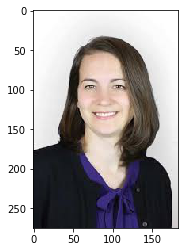

This is a human and they look like a Poodle with 17.2855004668 percent certainty


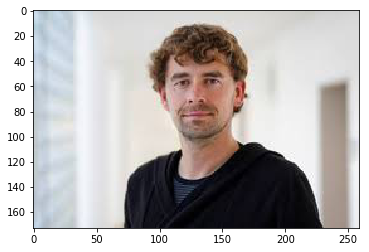

This is a human and they look like a Chinese_crested with 20.0125262141 percent certainty


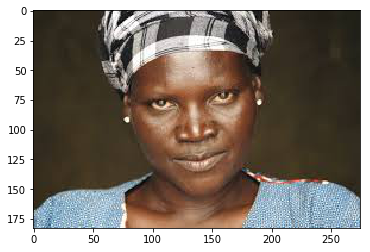

This does not look a dog or a human to me...


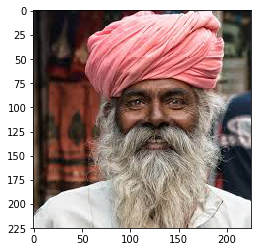

This is a dog and they look like a American_eskimo_dog with 96.2212383747 percent certainty


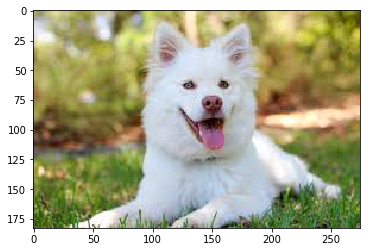

This is a dog and they look like a Beagle with 98.7897694111 percent certainty


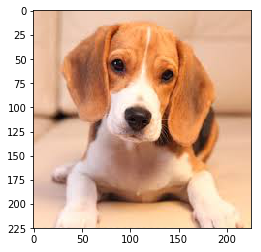

This is a dog and they look like a Labrador_retriever with 91.4149999619 percent certainty


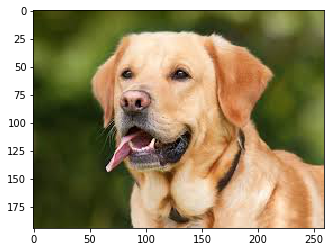

This is a dog and they look like a American_staffordshire_terrier with 99.8169183731 percent certainty


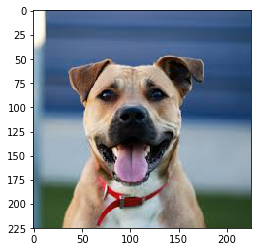

This does not look a dog or a human to me...


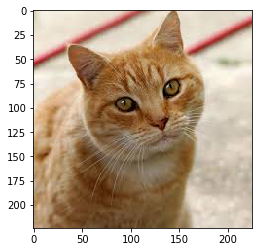

This does not look a dog or a human to me...


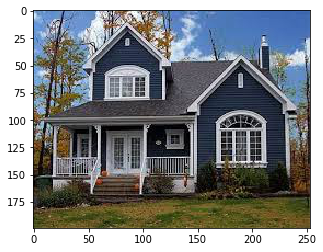

This does not look a dog or a human to me...


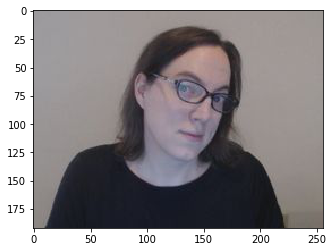

In [67]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
dog_or_human("./test_images/person1.jpg")
dog_or_human("./test_images/person2.jpg")
dog_or_human("./test_images/person3.jpg")
dog_or_human("./test_images/person4.jpg")
dog_or_human("./test_images/dog1.jpg")
dog_or_human("./test_images/dog2.jpg")
dog_or_human("./test_images/dog3.jpg")
dog_or_human("./test_images/dog4.jpg")
dog_or_human("./test_images/cat.jpg")
dog_or_human("./test_images/house.jpg")
dog_or_human("./test_images/me_sm.jpg")